In [1]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
from mlxtend import plotting
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score,mean_squared_error, r2_score, recall_score, precision_score, confusion_matrix, classification_report, roc_curve, plot_roc_curve, precision_recall_curve
from sklearn import metrics
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
test_set = pd.read_csv("test_set.csv")
train_set = pd.read_csv("train_set.csv")

In [3]:
y_test = test_set["DEATH_EVENT"]
y_train = train_set["DEATH_EVENT"]
X_train = train_set.drop("DEATH_EVENT", axis=1)
X_test = test_set.drop("DEATH_EVENT", axis=1)

In [4]:
train_set["DEATH_EVENT"].value_counts(normalize = True)
#NIEZBALANSOWANY DATASET

0    0.677824
1    0.322176
Name: DEATH_EVENT, dtype: float64

# LOGISTIC REGRESSION

#### LOGISTIC REGRESSION FEATURE IMPORTANCE

In [4]:
sc = StandardScaler()
X_train_sc0 = sc.fit_transform(X_train)
X_test_sc0 = sc.transform(X_test)

In [5]:
model0 = LogisticRegression(max_iter=1000)
model0.fit(X_train_sc0, y_train)

LogisticRegression(max_iter=1000)

In [6]:
importance = model0.coef_[0]

In [17]:
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
print(X_train.columns)

Feature: 0, Score: 0.59956
Feature: 1, Score: -0.05525
Feature: 2, Score: 0.13273
Feature: 3, Score: 0.13604
Feature: 4, Score: -0.94139
Feature: 5, Score: 0.08288
Feature: 6, Score: -0.32582
Feature: 7, Score: 0.63120
Feature: 8, Score: -0.11134
Feature: 9, Score: -0.35875
Feature: 10, Score: -0.09936
Feature: 11, Score: -1.51184
Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'],
      dtype='object')


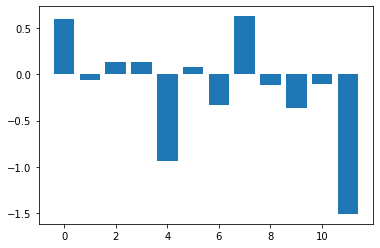

In [11]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### FEATURES SELECTION

In [4]:
X_train_clip= X_train[['age', 'ejection_fraction', 'serum_creatinine','sex', 'time']]
X_test_clip= X_test[['age', 'ejection_fraction', 'serum_creatinine', 'sex', 'time']]

In [5]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_clip)
X_test_sc = sc.transform(X_test_clip)

In [6]:
param_grid = {'class_weight': ["balanced"],
              'penalty' : ['l1','l2','elasticnet', 'none'],
              'C':[0.01,0.1,0.2,0.3,0.4,0.5],
              'solver'  : ['liblinear','newton-cg', 'lbfgs']
             }

In [7]:
model = LogisticRegression(random_state=42)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring = 'recall')
grid_search.fit(X_train_sc, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs']},
             scoring='recall')

In [8]:
best_param_no = grid_search.best_index_ 
print('Best parameters:', grid_search.best_params_, '(no. {0})'.format(best_param_no))
print('Best parameters score:', grid_search.best_score_)

Best parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'} (no. 3)
Best parameters score: 0.8316666666666667


In [9]:
best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test_sc)
y_score = best_log_reg.predict_proba(X_test_sc)[:, 1]

In [10]:
print("Confusion matrix:", confusion_matrix(y_test, y_pred))
print("Raport klasyfikacyjny: \n", classification_report(y_test, y_pred, target_names = ['Heart Not Failed','Heart Failed']))

Confusion matrix: [[31 10]
 [ 4 15]]
Raport klasyfikacyjny: 
                   precision    recall  f1-score   support

Heart Not Failed       0.89      0.76      0.82        41
    Heart Failed       0.60      0.79      0.68        19

        accuracy                           0.77        60
       macro avg       0.74      0.77      0.75        60
    weighted avg       0.80      0.77      0.77        60



In [11]:
print("-----Test set scores for Logistic Regression-----") 
print("Accuracy: {:.4f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precision: {:.4f}".format(metrics.precision_score(y_test, y_pred)))
print("Recall: {:.4f}".format(metrics.recall_score(y_test, y_pred)))
print("F1_score: {:.4f}".format(metrics.f1_score(y_test, y_pred)))
print("Roc_auc_score: {:.4f}".format(roc_auc_score(y_test, y_score)))
print("F-beta: {:.4f}".format(metrics.fbeta_score(y_test, y_pred, beta=2.0)))

-----Test set scores for Logistic Regression-----
Accuracy: 0.7667
Precision: 0.6000
Recall: 0.7895
F1_score: 0.6818
Roc_auc_score: 0.8716
F-beta: 0.7426


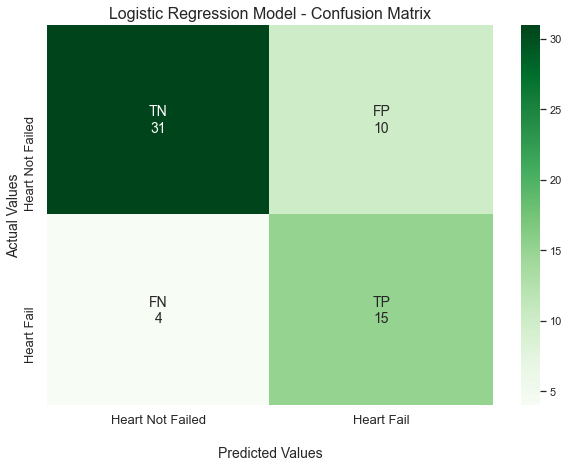

In [12]:
sns.set(rc={"figure.figsize":(10, 7)}) 
cm = confusion_matrix(y_test, y_pred)

group_names = ['TN','FP','FN','TP']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels,  fmt='', cmap='Greens',annot_kws={'size':14})

ax.set_title("Logistic Regression Model - Confusion Matrix", fontsize=16);
ax.set_xlabel('\nPredicted Values',fontsize=14)
ax.set_ylabel('Actual Values',fontsize=14);

ax.xaxis.set_ticklabels(["Heart Not Failed","Heart Fail"],fontsize=13)
ax.yaxis.set_ticklabels(["Heart Not Failed","Heart Fail"],fontsize=13)


plt.show()

# XGBOOST CLASSIFIER

#### XGBOOST FEATURE IMPORTANCE

In [13]:
xg_clas0 = xgb.XGBClassifier(seed=123)
xg_clas0.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

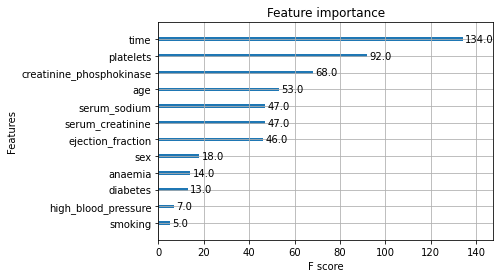

In [6]:
xgb.plot_importance(xg_clas0)

#### FEATURES SELECTION

In [14]:
X_train_clip= X_train[['time', 'age', 'platelets', 'creatinine_phosphokinase', 'serum_creatinine']]
X_test_clip= X_test[['time', 'age', 'platelets', 'creatinine_phosphokinase', 'serum_creatinine']]

In [15]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_clip)
X_test_sc = sc.transform(X_test_clip)

In [24]:
run_xboost = True

if run_xboost:
    parameter_grid = {
                "scale_pos_weight": [8],
                "objective": ["reg:logistic"],
                 "n_estimators": [10,20,100,200],
                 'max_depth' : [3,4,5, 6, 7, 8],
                 'gamma': [0,0.2, 0.4, 0.8, 1.5]
                 }
    xg_clas_Sc = XGBClassifier(random_state=42)
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(xg_clas_Sc,
                               scoring='roc_auc',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1,
                               n_jobs= -1
                              )

    grid_search.fit(X_train_sc, y_train)
    xg_clas_Sc = grid_search.best_estimator_
    y_pred = xg_clas_Sc.predict(X_test_sc)
    y_score = xg_clas_Sc.predict_proba(X_test_sc)[:, 1]
    print('Best parameters: {}'.format(grid_search.best_params_))
    print('Best score: {}'.format(grid_search.best_score_))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'gamma': 0.8, 'max_depth': 3, 'n_estimators': 20, 'objective': 'reg:logistic', 'scale_pos_weight': 8}
Best score: 0.9004146938131313


In [25]:
print("Confusion matrix:", confusion_matrix(y_test, y_pred))
print("Raport klasyfikacyjny: \n", classification_report(y_test, y_pred,target_names = ['Heart Not Failed','Heart Failed']))

Confusion matrix: [[36  5]
 [ 3 16]]
Raport klasyfikacyjny: 
                   precision    recall  f1-score   support

Heart Not Failed       0.92      0.88      0.90        41
    Heart Failed       0.76      0.84      0.80        19

        accuracy                           0.87        60
       macro avg       0.84      0.86      0.85        60
    weighted avg       0.87      0.87      0.87        60



In [18]:
print("-----Test set scores for XGBoostClassifier-----") 
print("Accuracy: {:.4f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precision: {:.4f}".format(metrics.precision_score(y_test, y_pred)))
print("Recall: {:.4f}".format(metrics.recall_score(y_test, y_pred)))
print("F1_score: {:.4f}".format(metrics.f1_score(y_test, y_pred)))
print("Roc_auc_score: {:.4f}".format(roc_auc_score(y_test, y_score)))
print("F-beta: {:.4f}".format(metrics.fbeta_score(y_test, y_pred, beta=2.0)))

-----Test set scores for XGBoostClassifier-----
Accuracy: 0.8667
Precision: 0.7619
Recall: 0.8421
F1_score: 0.8000
Roc_auc_score: 0.8813
F-beta: 0.8247


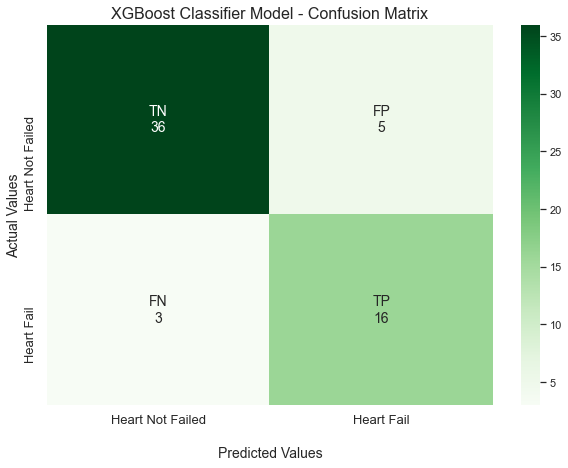

In [19]:
sns.set(rc={"figure.figsize":(10, 7)}) 
cm = confusion_matrix(y_test, y_pred)

group_names = ['TN','FP','FN','TP']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels,  fmt='', cmap='Greens',annot_kws={'size':14})

ax.set_title("XGBoost Classifier Model - Confusion Matrix", fontsize=16);
ax.set_xlabel('\nPredicted Values',fontsize=14)
ax.set_ylabel('Actual Values',fontsize=14);

ax.xaxis.set_ticklabels(["Heart Not Failed","Heart Fail"],fontsize=13)
ax.yaxis.set_ticklabels(["Heart Not Failed","Heart Fail"],fontsize=13)


plt.show()

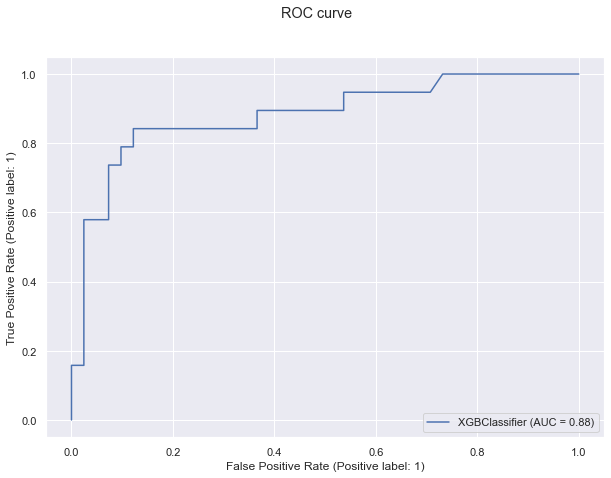

In [20]:
sns.set(rc={"figure.figsize":(10, 7)}) 
fig = plot_roc_curve(xg_clas_Sc,X_test_sc,y_test)
fig.figure_.suptitle("ROC curve")
plt.show() 

Text(0, 0.5, 'Precision')

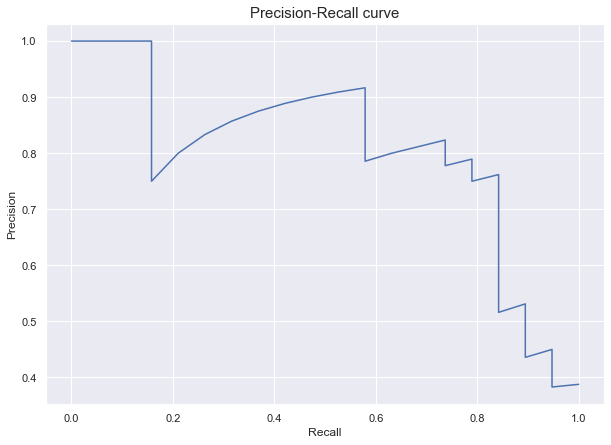

In [21]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plt.figure(figsize=(10, 7))
plt.plot(recall, precision)
plt.title("Precision-Recall curve",fontsize=15)
plt.xlabel("Recall")
plt.ylabel("Precision")